In [2]:
import anndata
import pixelator
import torch
import scvi
import scipy
# from scvi import autotune

import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection

# import ray
# from ray import tune

from pathlib import Path


from PixelGen.pxl_utils import train_model, get_model_latents, convert_polarization_to_feature_matrix, \
     convert_colocalization_to_feature_matrix, download_pxl
from PixelGen.scvi_utils import plot_losses, pca_neighbors_umap, calc_PCA, add_one_hot_encoding_obsm, plot_cumulative_variance
from PixelGen.common_utils import standardize, std_clip, filter_hv, split_pair_column, filter_df_by_two_columns, rank_plot
from PixelGen.metrics import MultiModalVIMetrics, distr_autocorrelation_in_latent
from PixelGen.multimodalvi import MultiModalSCVI
from PixelGen.multimodalvae import MultiModalVAE, AggMethod, D
from PixelGen.enums import AggMethod, D

from pixelator.plot import molecule_rank_plot, cell_count_plot, scatter_umi_per_upia_vs_tau
from pixelator.statistics import clr_transformation
from pixelator.analysis.normalization import dsb_normalize


from sklearn.preprocessing import StandardScaler, MinMaxScaler 


import tempfile

from scvi import REGISTRY_KEYS
from scvi.module.base import (
    BaseModuleClass,
    LossOutput,
    PyroBaseModuleClass,
    auto_move_data,
)
from torch.distributions import NegativeBinomial, Normal, Poisson, MixtureSameFamily, Beta
from torch.distributions import kl_divergence as kl



# from cytovi import CytoVI

print(torch.cuda.is_available())


scvi.settings.seed = 0
print("Last run with scvi-tools version:", scvi.__version__)
sc.set_figure_params(figsize=(6, 6), frameon=False)
sns.set_theme()
torch.set_float32_matmul_precision("high")
CMAP = 'RdBu_r'
save_dir = tempfile.TemporaryDirectory()

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"
%load_ext autoreload
%autoreload 2

Seed set to 0


True
Last run with scvi-tools version: 1.2.2.post2


In [3]:
DATA_DIR = Path('PixelGen/datasets/pbmc-pha-v2.0')

FILENAMES = [
    "Sample05_V2_PBMC_r1.layout.dataset.pxl",
    "Sample06_V2_PBMC_r2.layout.dataset.pxl",
    "Sample07_V2_PHA_PBMC_r1.layout.dataset.pxl",
    "Sample08_V2_PHA_PBMC_r2.layout.dataset.pxl",
]

SAMPLE_NAMES = [
    "resting_r1", 
    "resting_r2",
    "stimulated_r1", 
    "stimulated_r2",
]

COMBINED_FILENAME = "combined_resting_PHA_data.pxl"
COMBINED_PATH = DATA_DIR / COMBINED_FILENAME

pg_data = pixelator.read(COMBINED_PATH)

In [ ]:
annotations = anndata.read_h5ad('PixelGen/datasets/pbmc-pha-v2.0/combined_data_coloc_autocorr_with_norm.h5ad')


AnnData object with n_obs × n_vars = 3763 × 75
    obs: 'pixels', 'a_pixels', 'b_pixels', 'antibodies', 'molecules', 'reads', 'mean_reads_per_molecule', 'median_reads_per_molecule', 'mean_b_pixels_per_a_pixel', 'median_b_pixels_per_a_pixel', 'mean_a_pixels_per_b_pixel', 'median_a_pixels_per_b_pixel', 'a_pixel_b_pixel_ratio', 'mean_molecules_per_a_pixel', 'median_molecules_per_a_pixel', 'leiden', 'tau_type', 'tau', 'sample', 'n_antibodies_by_counts', 'log1p_n_antibodies_by_counts', 'total_counts', 'log1p_total_counts', 'sample_class', 'cell_type'
    var: 'antibody_count', 'components', 'antibody_pct', 'nuclear', 'control', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cell_type_colors', 'coloc_info', 'counts_per_sample', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'sample_class_colors', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'autocorr_actual', 'a

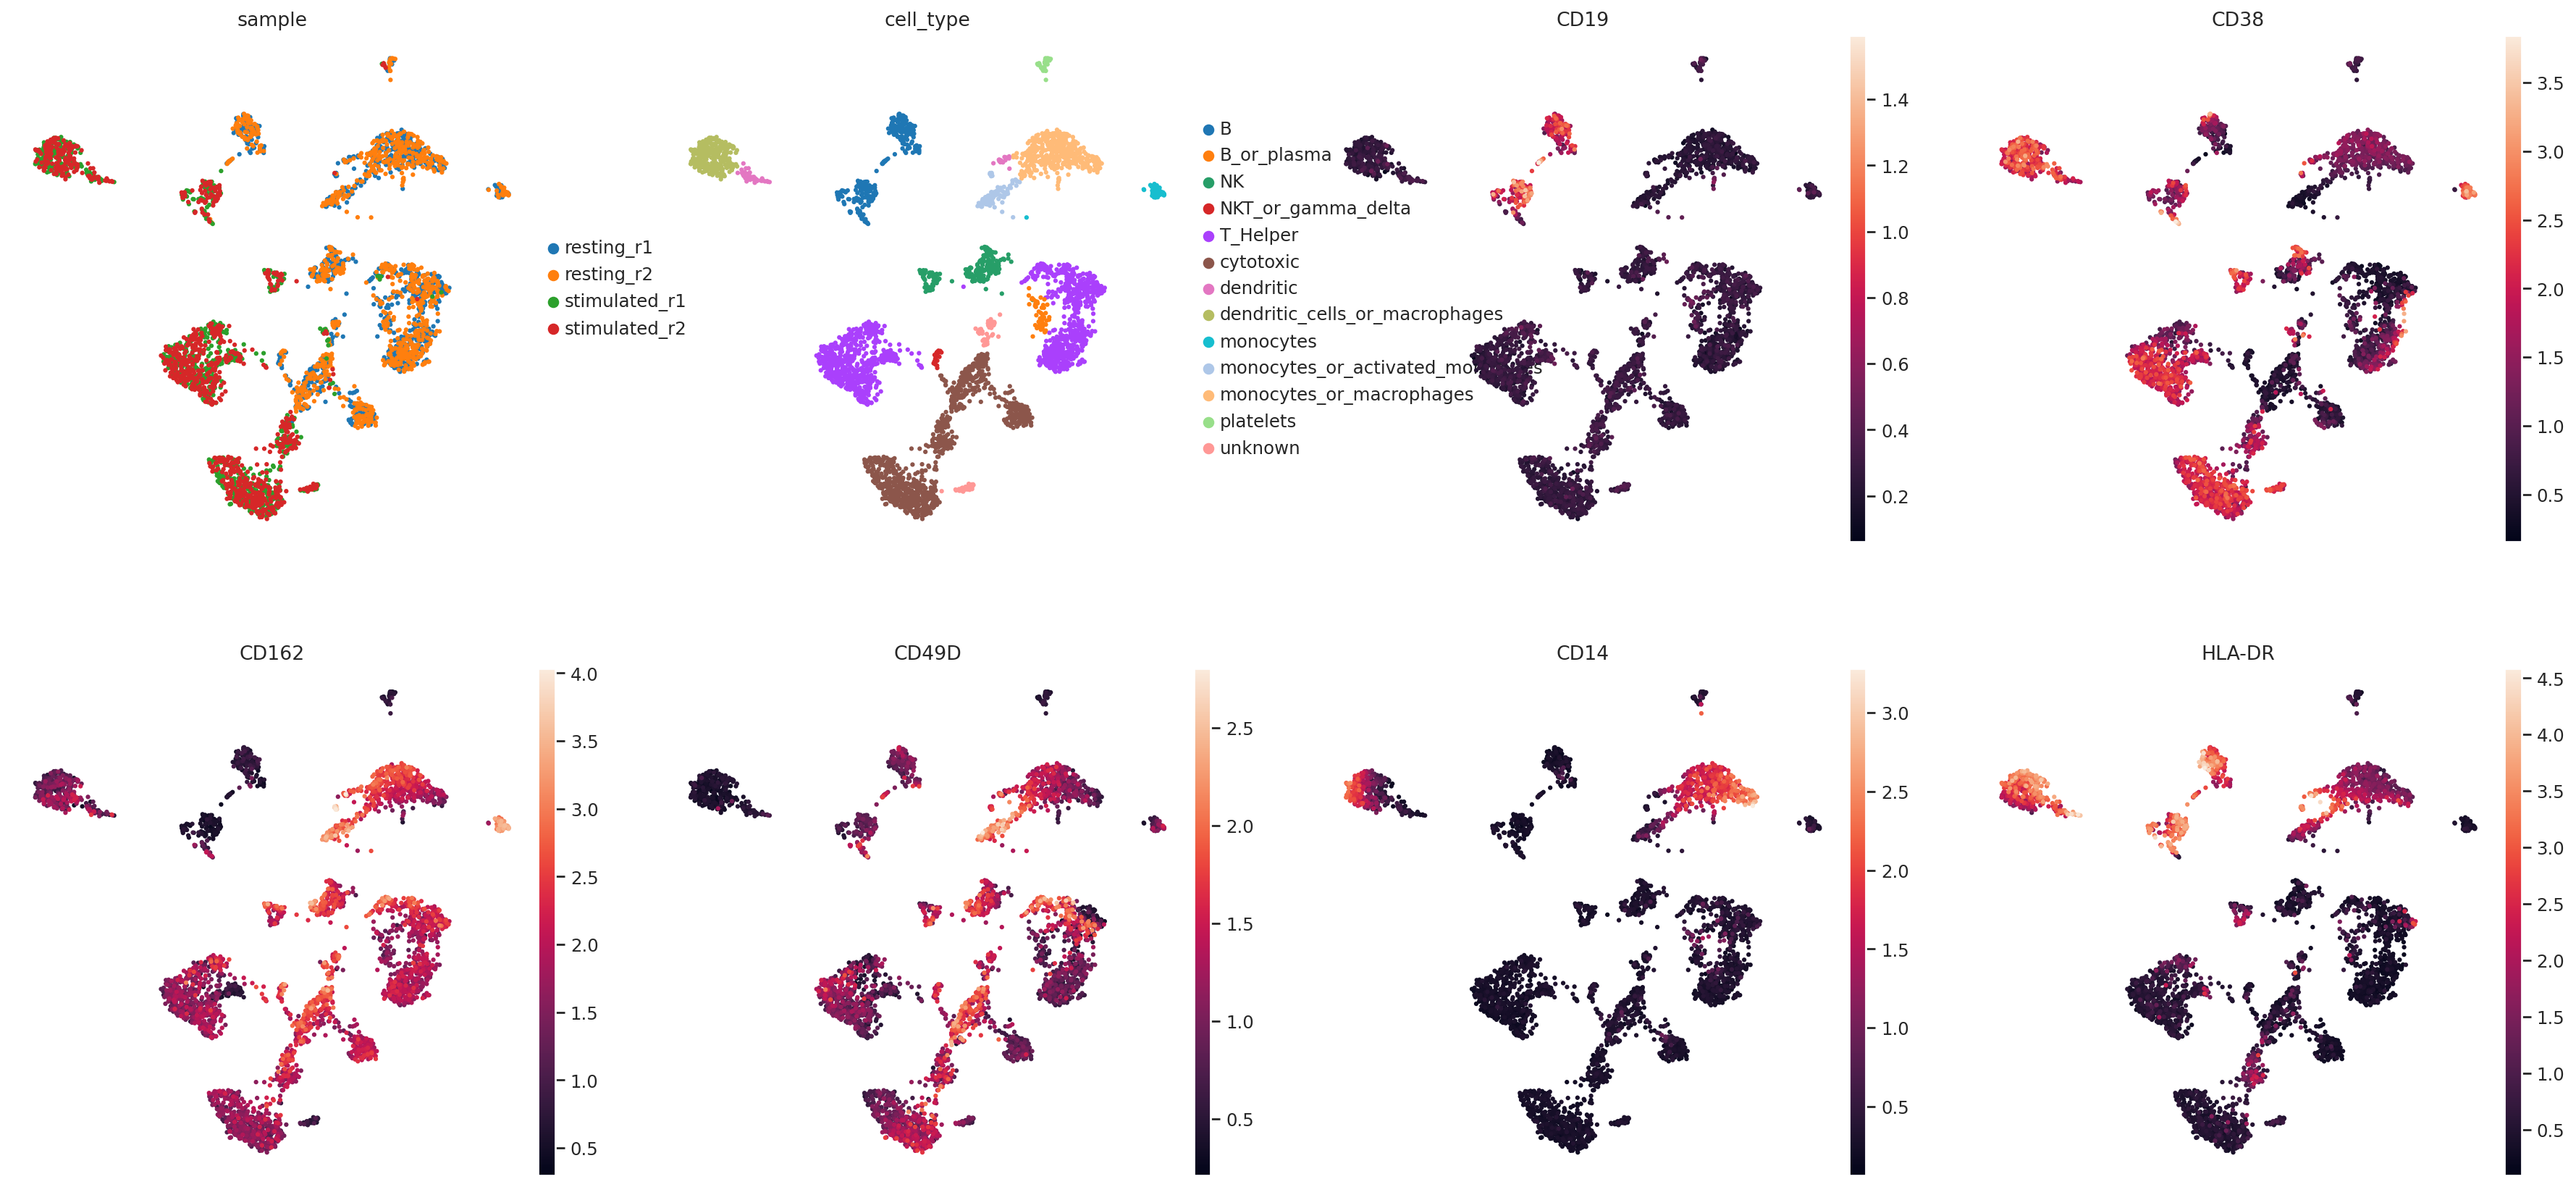

In [19]:
sc.pl.umap(annotations, color=['sample', 'cell_type', 'CD19', 'CD38', 'CD162', 'CD49D', 'CD14', 'HLA-DR'], layer='clr')

In [ ]:
map = {
    'B_or_plasma': 'platelets',
    
}

In [33]:
sc.tl.rank_genes_groups(annotations, groupby='leiden', layer='log1p', method='wilcoxon', groups='all', reference='rest', use_raw=False)
# sc.pl.rank_genes_groups_dotplot(annotations, groupby='leiden', values_to_plot='logfoldchanges', n_genes=3, min_logfoldchange=1, vcenter=0, cmap='coolwarm')

/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/projects/nyosef/eitangr/miniconda3/envs/pixelgen-scvi/l

In [32]:
top_markers = sc.get.rank_genes_groups_df(annotations, group=None).groupby('group', group_keys=False).apply(
    lambda g: g.nlargest(10, 'logfoldchanges'))
top_markers['scores'] = [f'{s: .2f}' for s in top_markers['scores']]
for i in range(25):
    group_markers = top_markers[top_markers['group'] == f'{i}']
    print(f'Group {i} (marker, score): {list(zip(group_markers["names"], group_markers["scores"]))}')

Group 0 (marker, score): [('CD8', ' 30.72'), ('CD71', ' 31.12'), ('CD27', ' 32.26'), ('CD25', ' 25.04'), ('CD7', ' 27.29'), ('CD2', ' 25.87'), ('CD38', ' 23.76'), ('CD5', ' 13.53'), ('CD26', ' 20.79'), ('CD3E', ' 11.26')]
Group 1 (marker, score): [('CD36', ' 33.13'), ('CD35', ' 31.98'), ('CD14', ' 32.59'), ('CD64', ' 32.80'), ('CD11c', ' 29.60'), ('CD32', ' 23.79'), ('CD328', ' 30.46'), ('CD11b', ' 31.99'), ('CD86', ' 25.18'), ('CD33', ' 33.04')]
Group 2 (marker, score): [('CD71', ' 21.96'), ('CD25', ' 23.91'), ('CD5', ' 24.44'), ('CD27', ' 23.39'), ('CD4', ' 20.09'), ('CD7', ' 25.24'), ('CD2', ' 22.73'), ('CD278', ' 26.34'), ('CD3E', ' 11.98'), ('CD38', ' 18.87')]
Group 3 (marker, score): [('CD4', ' 26.65'), ('CD3E', ' 26.47'), ('CD45RB', ' 26.45'), ('CD45RA', ' 14.46'), ('CD5', ' 15.83'), ('CD26', ' 16.95'), ('CD52', ' 20.62'), ('CD27', ' 12.47'), ('CD59', ' 15.08'), ('CD43', ' 6.96')]
Group 4 (marker, score): [('CD54', ' 27.20'), ('CD274', ' 27.20'), ('CD40', ' 26.11'), ('HLA-DR', '

/tmp/ipykernel_4096025/1425382937.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_markers = sc.get.rank_genes_groups_df(annotations, group=None).groupby('group', group_keys=False).apply(
/tmp/ipykernel_4096025/1425382937.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_markers = sc.get.rank_genes_groups_df(annotations, group=None).groupby('group', group_keys=False).apply(


In [ ]:
annot_dict = {
    '0': 'Cytotoxic_T_Activated',
    '1': 'Monocytes',
    '2': 'Helper_T_Activated',
    '3': 'Helper_T_Naive',
    '4': 'Monocytes_Activated',
    '5': 'Helper_T_Memory',
    '6': 'Cytotoxic_T_Memory',
    '7': 'NK',
    '8': 'B',
    '9': 'Cytotoxic_T_Naive',
    '10': 'B_Activated',
    '11': 'T_Reg_Activated',
    '12': 'Cytotoxic_T',
    '13': 'NK',
    '14': 'Helper_T_Activated',
    '15': 'NK_Activated',
    '16': 'Helper_T_Memory',
    '17': 'Platelets',
    '18': 'Unknown',
    '19': 'Monocytes',
    '20': 'Monoctyes_Activated',
    '21': 'Cytotoxic_T_Activated',
    '22': 'Platelets',
    '23': 'NKT',
    '24': 'Dendritic'
}

<Axes: ylabel='Count'>

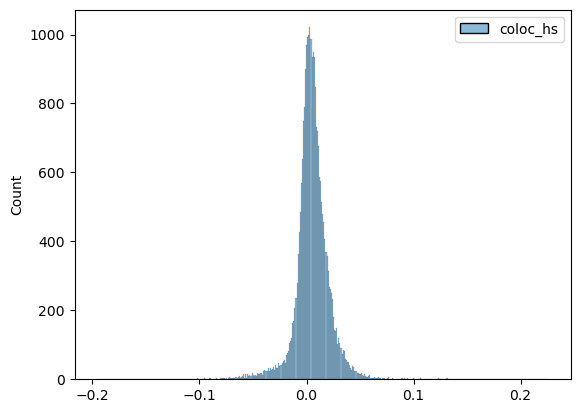

In [18]:
adata = anndata.read_h5ad(DATASET_DIR / 'TEST_pbmcs_pha_with_hs.h5ad')
sns.histplot(adata.uns['coloc_hs'])